# **Deepcell Mesmer**
---
## Introduction
This notebook performs the GPU enabled deepcell Mesmer pipeline for whole-cell segmentation. 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JoeBlackSci/high-plex-whole-cell-segmentation-mp2/blob/main/notebooks/deepcell_mesmer_gpu.ipynb)

This notebook is adapted from the [Mesmer-Application.ipynb](https://github.com/vanvalenlab/deepcell-tf/blob/master/notebooks/applications/Mesmer-Application.ipynb) which is part of the ``deepcell-tf`` documentation: https://deepcell.readthedocs.io/ and freely available in github: https://github.com/vanvalenlab/deepcell-tf/
    
[LICENSE](https://github.com/vanvalenlab/deepcell-tf/blob/master/LICENSE)

---

**Notebook Author:** Joseph Blackwell  
School of Life Sciences, University of Warwick, United Kingdom  
Contact: j.blackwell@warwick.ac.uk

## Configuration

If using colab ensure you are connected to a GPU enabled session. 

Go to Runtime -> Change runtime type and set hardware accelerator to GPU.

## Installation

In [ ]:
!pip install deepcell

## Sample data

In [2]:
# Download multiplex data
from deepcell.datasets import multiplex_tissue
((X_train, y_train),(X_test, y_test)) = multiplex_tissue.load_data()

In [3]:
from deepcell.utils.plot_utils import create_rgb_image

# create rgb overlay of image data for visualization 
# (overwritten if user data is supplied)
rgb_images = create_rgb_image(X_train, channel_colors=['green', 'blue'])

# set imgs for segmentation 
# (overwritten if user data is supplied)
imgs = X_train

# set img names for saving
# (overwritten if user data is supplied)
img_names = None

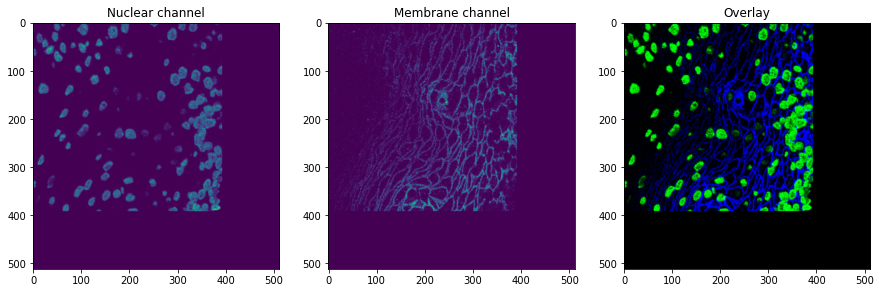

In [4]:
from random import randint
from matplotlib import pyplot as plt

# Select random index for image visualisation
idx = randint(0, X_train.shape[0] - 1)

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(X_train[idx, ..., 0])
ax[1].imshow(X_train[idx, ..., 1])
ax[2].imshow(rgb_images[idx, ...])

ax[0].set_title('Nuclear channel')
ax[1].set_title('Membrane channel')
ax[2].set_title('Overlay')

plt.show()

## User data

User images should be supplied as two channel tiff files according to [deepcell specifications](https://github.com/vanvalenlab/intro-to-deepcell/tree/master/pretrained_models#formatting-data-for-pre-trained-models). **The nuclear channel must be the first channel**.

In [5]:
from google.colab import drive

# Mount drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
from glob import glob

# Input directory
indir = '/content/drive/MyDrive/seg/imgs/'

# Glob filenames
files = sorted(glob(indir + "*.tif"))

In [8]:
import skimage.io
import os.path
import numpy as np

from deepcell.utils.plot_utils import create_rgb_image

# Loading images
imgs = [skimage.io.imread(f) for f in files]
img_names = [os.path.basename(file) for file in files]
nimg = len(imgs)

# Reformating imgs to 4D np array required for segmentation
imgs = [np.moveaxis(img, 0, -1) for img in imgs]
imgs = np.stack(imgs)

# Converting imgs to rgb images for visualisation
rgb_images = create_rgb_image(imgs, ['green', 'blue'])

print(nimg, 'image(s) loaded')

2 image(s) loaded


The imgs object should be 4D with dimensions: image index, rows, columns, channels in that order. This can be checked with the following cell.

e.g. `imgs shape: (16, 512, 512, 2)`

In [9]:
print('imgs shape:', imgs.shape)

imgs shape: (2, 512, 512, 2)


In [ ]:
from random import randint
from matplotlib import pyplot as plt

# Select random index for image visualisation
idx = randint(0, imgs.shape[0] - 1)

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(imgs[idx, ..., 0])
ax[1].imshow(imgs[idx, ..., 1])
ax[2].imshow(rgb_images[idx, ...])

ax[0].set_title('Nuclear channel')
ax[1].set_title('Membrane channel')
ax[2].set_title('Overlay')

plt.show()

## Whole Cell Segmentation

### Initialize Mesmer model

The application will download pretrained weights for tissue segmentation. For more information about application objects, please see the deepcell [documentation](https://deepcell.readthedocs.io/en/master/API/deepcell.applications.html).

In [5]:
from deepcell.applications import Mesmer
app = Mesmer()

## Use the application to generate labeled images

Typically, neural networks perform best on test data that is similar to the training data. In the realm of biological imaging, the most common difference between datasets is the resolution of the data measured in microns per pixel. The training resolution of the model can be identified using `app.model_mpp`.

In [6]:
print('Training Resolution:', app.model_mpp, 'microns per pixel')

Training Resolution: 0.5 microns per pixel


The resolution of the input data can be specified in `app.predict` using the `image_mpp` option. The `Application` will rescale the input data to match the training resolution and then rescale to the original size before returning the labeled image.

In [7]:
segmentation_predictions = app.predict(imgs, image_mpp=0.5)

In [8]:
# create overlay of predictions
from deepcell.utils.plot_utils import make_outline_overlay
overlay_data = make_outline_overlay(rgb_data=rgb_images, predictions=segmentation_predictions)

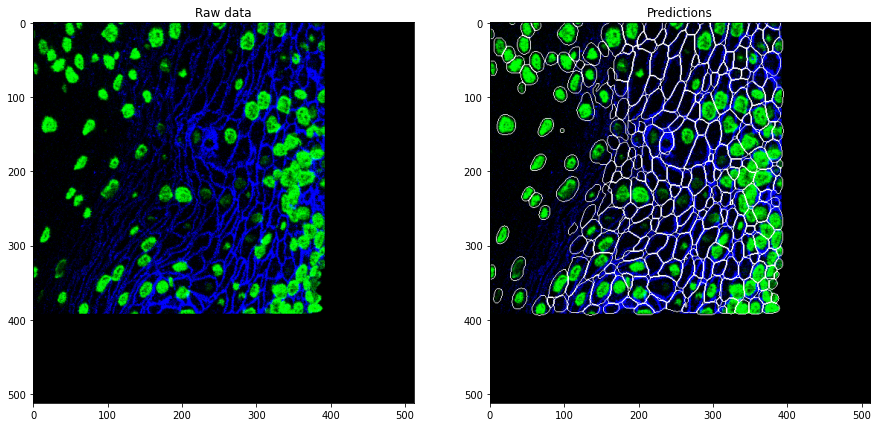

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(rgb_images[idx, ...])
ax[1].imshow(overlay_data[idx, ...])
ax[0].set_title('Raw data')
ax[1].set_title('Predictions')
plt.show()

## Nuclear Cell Segmentation

In addition to predicting whole-cell segmentation, Mesmer can also be used for nuclear predictions

In [10]:
segmentation_predictions_nuc = app.predict(imgs, image_mpp=0.5, compartment='nuclear')

In [11]:
overlay_data_nuc = make_outline_overlay(rgb_data=rgb_images, predictions=segmentation_predictions_nuc)

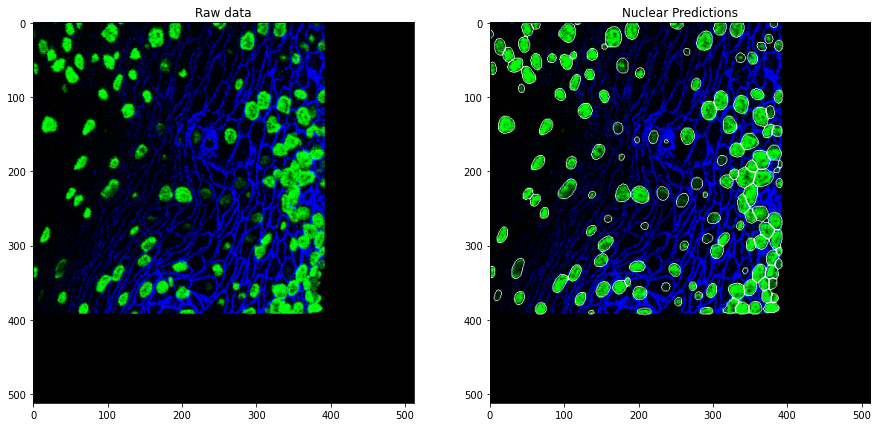

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(rgb_images[idx, ...])
ax[1].imshow(overlay_data_nuc[idx, ...])
ax[0].set_title('Raw data')
ax[1].set_title('Nuclear Predictions')
plt.show()

## Saving segmentation masks

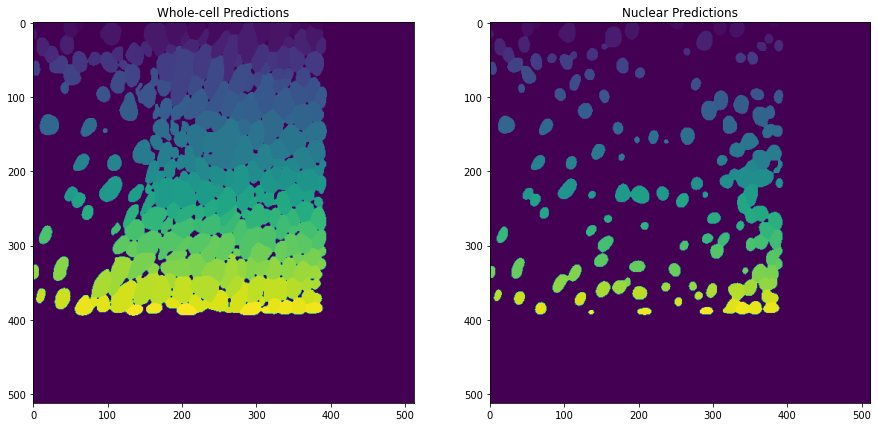

In [13]:
# Visualise segmentation masks

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(segmentation_predictions[idx, ..., 0])
ax[1].imshow(segmentation_predictions_nuc[idx, ..., 0])
ax[0].set_title('Whole-cell Predictions')
ax[1].set_title('Nuclear Predictions')
plt.show()

### Save whole-cell segmentation

In [15]:
from skimage.io import imsave

# Define directory to write to
outdir = '/content/drive/MyDrive/seg/predictions'

feature = 'whole-cell_feature'
use_img_names = True

for i, prediction in enumerate(segmentation_predictions):

    if img_names and use_img_names:
        filename = img_names[i].split('.', 1)[0]
        outpath = outdir + '/' + filename + '_' + feature + '.tif'
    else:
        outpath = outdir + '/' + feature + '_' + str(i) + '.tif'

    imsave(outpath, prediction, check_contrast=False)

### Save nuclear segmentation

In [16]:
from skimage.io import imsave

# Define directory to write to
outdir = '/content/drive/MyDrive/seg/predictions'

feature = 'nuclear_feature'
use_img_names = True

for i, prediction in enumerate(segmentation_predictions_nuc):

    if img_names and use_img_names:
        filename = img_names[i].split('.', 1)[0]
        outpath = outdir + '/' + filename + '_' + feature + '.tif'
    else:
        outpath = outdir + '/' + feature + '_' + str(i) + '.tif'

    imsave(outpath, prediction, check_contrast=False)